<a href="https://colab.research.google.com/github/zinseo964/dam_flow/blob/main/dam_lstm(notincludesthepreviousdam).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
""" LSTM stock price prediction: stacked LSTM """

# import libraries
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
rain_data = pd.read_csv('/content/drive/MyDrive/240410/rain_day.csv', encoding='utf-8')
dam_data = pd.read_csv('/content/drive/MyDrive/240410/total_dam.csv', encoding='utf-8')

In [3]:
dam_data = dam_data.drop('Unnamed: 0', axis = 1)

In [4]:
data = []

In [5]:
data = pd.merge( dam_data,rain_data, on='date', how='inner')

In [6]:
data = data.fillna(0)

In [7]:
print(data)

             date     dam    90  100  101  211  212
0      1974-01-01  10.000   0.0  0.0  0.0  0.0  0.0
1      1974-01-02   9.000   0.0  0.0  0.0  0.0  0.0
2      1974-01-03   4.800   0.0  0.0  0.0  0.0  0.0
3      1974-01-04   6.100   0.0  0.0  0.0  0.0  0.0
4      1974-01-05   5.800   0.0  0.0  0.0  0.0  0.0
...           ...     ...   ...  ...  ...  ...  ...
18257  2023-12-27  25.873   0.0  0.0  0.0  0.0  0.0
18258  2023-12-28  21.186   0.0  0.0  0.0  0.0  0.0
18259  2023-12-29  20.887   0.0  0.0  0.0  0.0  0.0
18260  2023-12-30  29.183   0.7  2.3  9.9  6.8  8.5
18261  2023-12-31  25.803  26.8  6.0  5.3  3.1  4.9

[18262 rows x 7 columns]


In [8]:
# save original 'Open' prices for later
original_dam = data['dam'].values

In [9]:
# separate dates for future plotting
dates = pd.to_datetime(data['date'])

In [10]:
print(data)

             date     dam    90  100  101  211  212
0      1974-01-01  10.000   0.0  0.0  0.0  0.0  0.0
1      1974-01-02   9.000   0.0  0.0  0.0  0.0  0.0
2      1974-01-03   4.800   0.0  0.0  0.0  0.0  0.0
3      1974-01-04   6.100   0.0  0.0  0.0  0.0  0.0
4      1974-01-05   5.800   0.0  0.0  0.0  0.0  0.0
...           ...     ...   ...  ...  ...  ...  ...
18257  2023-12-27  25.873   0.0  0.0  0.0  0.0  0.0
18258  2023-12-28  21.186   0.0  0.0  0.0  0.0  0.0
18259  2023-12-29  20.887   0.0  0.0  0.0  0.0  0.0
18260  2023-12-30  29.183   0.7  2.3  9.9  6.8  8.5
18261  2023-12-31  25.803  26.8  6.0  5.3  3.1  4.9

[18262 rows x 7 columns]


In [11]:
# variables for training
cols = list(data)[1:7]

In [12]:
print(cols)

['dam', '90', '100', '101', '211', '212']


In [13]:
# new dataframe with only training data - 5 columns
data = data[cols].astype(float)

In [14]:
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(data)
dam_data_scaled = scaler.transform(data)

In [15]:
print(dam_data_scaled)

[[-0.26438616 -0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.26891176 -0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.28791927 -0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 ...
 [-0.21511599 -0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.17757163 -0.21848378 -0.13543747  0.4582759   0.29126708  0.35711289]
 [-0.19286815  1.61178172  0.09447481  0.12373822 -0.00937438  0.09384957]]


In [16]:
# split to train data and test data
n_train = int(0.9*dam_data_scaled.shape[0])
train_data_scaled = dam_data_scaled[0: n_train]
train_dates = dates[0: n_train]

test_data_scaled = dam_data_scaled[n_train:]
test_dates = dates[n_train:]
print(test_dates.head(5))

16435   2018-12-31
16436   2019-01-01
16437   2019-01-02
16438   2019-01-03
16439   2019-01-04
Name: date, dtype: datetime64[ns]


In [34]:
print(train_data_scaled[13])

[-0.28067831 -0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]


In [35]:
# data reformatting for LSTM
pred_days = 1  # prediction period
seq_len = 14   # sequence length = past days for future prediction.
input_dim = 5  # input_dimension = ['90', '100', '101', '211', '212']

trainX = []
trainY = []
testX = []
testY = []

for i in range(seq_len, n_train-pred_days +1):
    trainX.append(train_data_scaled[i - seq_len:i, 1:train_data_scaled.shape[1]])
    trainY.append(train_data_scaled[i + pred_days - 2:i + pred_days-1, 0])

for i in range(seq_len, len(test_data_scaled)-pred_days +1):
    testX.append(test_data_scaled[i - seq_len:i, 1:test_data_scaled.shape[1]])
    testY.append(test_data_scaled[i + pred_days - 2:i + pred_days-1, 0])

print(trainX[0])
print(trainY[0])

trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

[[-0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.26757136 -0.25971438 -0.26170736 -0.26126318 -0.26448106]
 [-0.25354633 -0.24107284 -0.26170736 -0.26126318 -0.26448106]
 [-0.26757136 -0.25350053 -0.26170736 -0.26126318 -0.26448106]
 [-0.26055885 -0.24107284 -0.26170736 -0.26126318 -0.26448106]
 [-0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]]
[-0.28067831]


In [19]:
print(trainY)

[[-0.26936432]
 [-0.28429879]
 [-0.28565647]
 ...
 [-0.28400915]
 [-0.28364258]
 [-0.2565071 ]]


In [20]:
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(16421, 14, 5) (16421, 1)
(1813, 14, 5) (1813, 1)


In [21]:
# LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), # (seq length, input dimension)
               return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(trainY.shape[1]))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
# specify your learning rate
learning_rate = 0.01
# create an Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
# compile your model using the custom optimizer
model.compile(optimizer=optimizer, loss='mse')

No weights found, training model from scratch
Epoch 1/30
462/462 [==============================] - 18s 20ms/step - loss: 0.3441 - val_loss: 0.1286
Epoch 2/30
462/462 [==============================] - 7s 15ms/step - loss: 0.1907 - val_loss: 0.1033
Epoch 3/30
462/462 [==============================] - 8s 18ms/step - loss: 0.1750 - val_loss: 0.1065
Epoch 4/30
462/462 [==============================] - 7s 15ms/step - loss: 0.1403 - val_loss: 0.1017
Epoch 5/30
462/462 [==============================] - 8s 18ms/step - loss: 0.1385 - val_loss: 0.0916
Epoch 6/30
462/462 [==============================] - 7s 15ms/step - loss: 0.1399 - val_loss: 0.1215
Epoch 7/30
462/462 [==============================] - 8s 18ms/step - loss: 0.1190 - val_loss: 0.1468
Epoch 8/30
462/462 [==============================] - 7s 15ms/step - loss: 0.1139 - val_loss: 0.0849
Epoch 9/30
462/462 [==============================] - 8s 18ms/step - loss: 0.1077 - val_loss: 0.1188
Epoch 10/30
462/462 [=======================

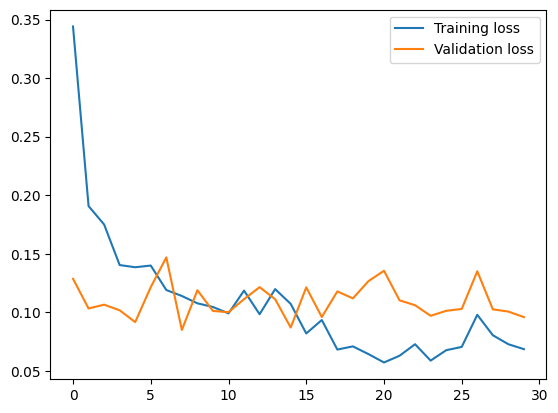

In [36]:
# Try to load weights
try:
    model.load_weights('/content/drive/MyDrive/240410/dam_lstm_nodam_weights.h5')
    print("Loaded model weights from disk")
except:
    print("No weights found, training model from scratch")
    # Fit the model
    history = model.fit(trainX, trainY, epochs=30, batch_size=32,
                    validation_split=0.1, verbose=1)
    # Save model weights after training
    model.save_weights('/content/drive/MyDrive/240410/dam_lstm_nodam_weights.h5')

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.show()

57/57 [==============================] - 0s 5ms/step
(1813, 1) (1813, 1)
(1813,)


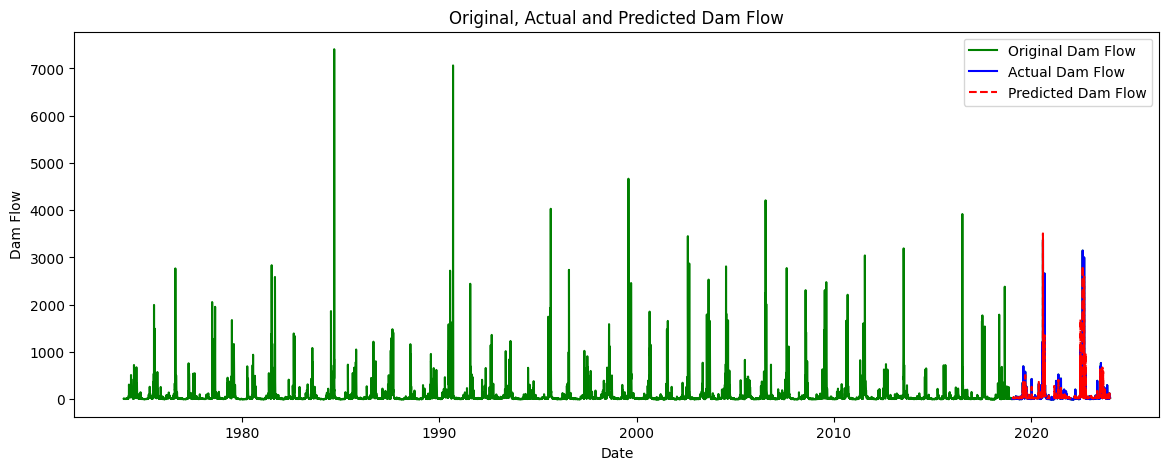

In [38]:
# prediction
prediction = model.predict(testX)
print(prediction.shape, testY.shape)

# generate array filled with means for prediction
mean_values_pred = np.repeat(scaler.mean_[np.newaxis, :], prediction.shape[0], axis=0)

# substitute predictions into the first column
mean_values_pred[:, 0] = np.squeeze(prediction)

# inverse transform
y_pred = scaler.inverse_transform(mean_values_pred)[:,0]

# generate array filled with means for testY
mean_values_testY = np.repeat(scaler.mean_[np.newaxis, :], testY.shape[0], axis=0)

# substitute testY into the first column
mean_values_testY[:, 0] = np.squeeze(testY)

# inverse transform
testY_original = scaler.inverse_transform(mean_values_testY)[:,0]
print(testY_original.shape)

# plotting
plt.figure(figsize=(14, 5))

# plot original 'Open' prices
plt.plot(dates, original_dam, color='green', label='Original Dam Flow')

# plot actual vs predicted
plt.plot(test_dates[seq_len:], testY_original, color='blue', label='Actual Dam Flow')
plt.plot(test_dates[seq_len:], y_pred, color='red', linestyle='--', label='Predicted Dam Flow')
plt.xlabel('Date')
plt.ylabel('Dam Flow')
plt.title('Original, Actual and Predicted Dam Flow')
plt.legend()
plt.show()

In [37]:
print(test_dates)

16435   2018-12-31
16436   2019-01-01
16437   2019-01-02
16438   2019-01-03
16439   2019-01-04
           ...    
18257   2023-12-27
18258   2023-12-28
18259   2023-12-29
18260   2023-12-30
18261   2023-12-31
Name: date, Length: 1827, dtype: datetime64[ns]


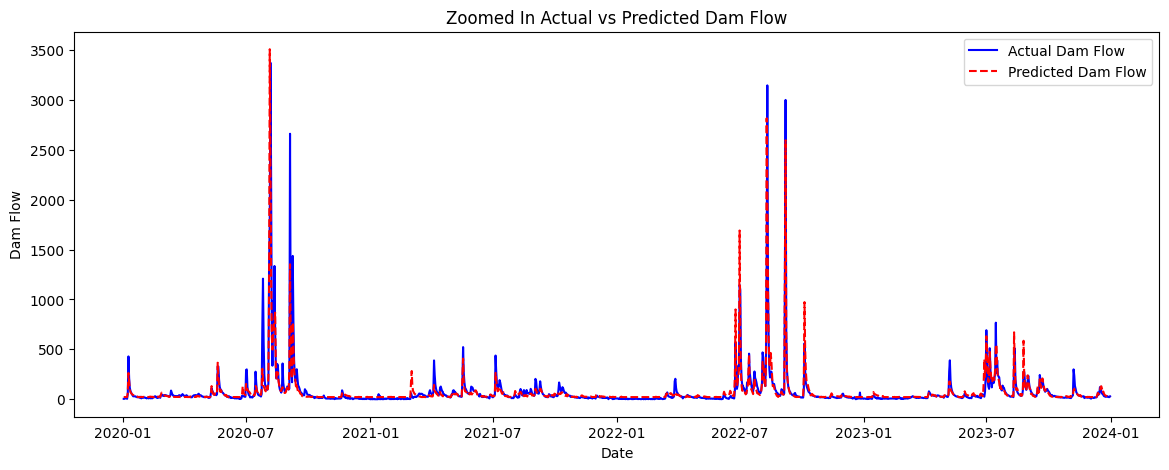

In [40]:
# Calculate the start and end indices for the zoomed plot
zoom_start = len(test_dates) - 365*4
zoom_end = len(test_dates)

# Create the zoomed plot
plt.figure(figsize=(14, 5))

# Adjust the start index for the testY_original and y_pred arrays
adjusted_start = zoom_start - seq_len

plt.plot(test_dates[zoom_start:zoom_end],
         testY_original[adjusted_start:zoom_end - zoom_start + adjusted_start],
         color='blue',
         label='Actual Dam Flow')

plt.plot(test_dates[zoom_start:zoom_end],
         y_pred[adjusted_start:zoom_end - zoom_start + adjusted_start ],
         color='red',
         linestyle='--',
         label='Predicted Dam Flow')

plt.xlabel('Date')
plt.ylabel('Dam Flow')
plt.title('Zoomed In Actual vs Predicted Dam Flow')
plt.legend()
plt.show()

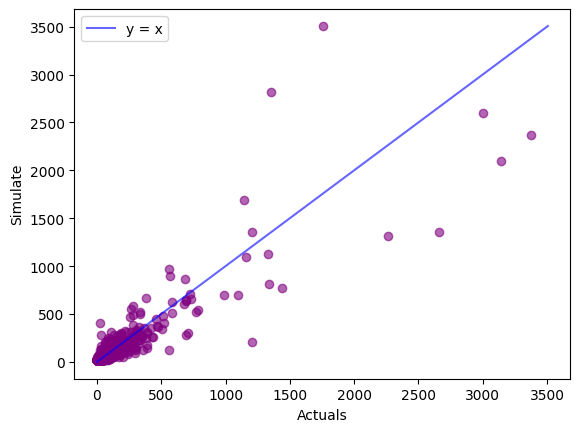

In [41]:
# 일대일 그래프
x = np.arange(0,max(max(testY_original), max(y_pred)))
y = x
plt.scatter(testY_original[:], y_pred[:], color = 'purple', alpha = 0.6)
plt.plot(x,y, color = 'blue', alpha = 0.6, label = 'y = x')
plt.xlabel('Actuals')
plt.ylabel('Simulate')

plt.legend()
plt.show()

In [42]:
#RMSE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(testY_original, y_pred))
print('RMSE : %.2f' %(rmse))

RMSE : 93.12


In [43]:
# NSE
from numpy import mean
num_sum1 = 0
num_sum2 = 0
num_avg = mean(testY_original[:])
for i in range(len(testY_original)):
  num1 = testY_original[i] - y_pred[i]
  num_sum1 += num1**2
  num2 = testY_original[i] - num_avg
  num_sum2 += num2**2

nse = 1 - (num_sum1 / num_sum2)
print('NSE : %f' %nse)

NSE : 0.780144


In [44]:
# PBIAS
num_sum1 = 0
for i in range(len(testY_original)):
  num1 = testY_original[i] - y_pred[i]
  num_sum1 += num1

pbias = (num_sum1 / np.sum(testY_original[:])) * 100
print('PBIAS : %f' %pbias)

PBIAS : -2.019724


In [45]:
#R^2
import math

num_sum1 = 0
num_sum2 = 0
num_sum3 = 0
act_avg = mean(testY_original[:])
pred_avg = mean(y_pred[:])
for i in range(len(testY_original)):
  num1 = (testY_original[i] - act_avg) * (y_pred[i] - pred_avg)
  num_sum1 += num1
  num2 = testY_original[i] - pred_avg
  num_sum2 += num2**2
  num3 = y_pred[i] - pred_avg
  num_sum3 += num3**2

r_square = (num_sum1 / (math.sqrt(num_sum2)* math.sqrt(num_sum3)))**2
print('R Square : %f' %r_square)

R Square : 0.780861
